In [235]:
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque

In [236]:
env = gym.make('Blackjack-v0')

In [250]:
class Agent():
    
    def __init__(self, nA=2, epsilon=1, epsilon_d=0.99999, epsilon_m = 0.05, alpha=0.015, gamma=1.0):
        self.nA = nA
        self.epsilon = epsilon
        self.epsilon_d = epsilon_d
        self.epsilon_m = epsilon_m
        self.alpha = alpha
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(nA))
        
    def select_action(self, state):
        probabilities = np.ones(self.nA)*self.epsilon/self.nA
        greedy_action = np.argmax(self.Q[state]) if state in Q else env.action_space.sample()
        probabilities[greedy_action] = 1 - self.epsilon + (self.epsilon/self.nA)
        action = np.random.choice(self.nA, p=probabilities)
        return action
    
    def MC_update(self, states, actions, rewards):
        discounts = np.array([self.gamma**1 for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            old_Q = self.Q[state][actions[i]]
            self.Q[state][actions[i]] = old_Q + self.alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)

In [251]:
def MC_blackjack(env, agent, num_episodes, window=1000):
    
    for i_episode in range(1, num_episodes+1):
        states = []
        actions = []
        rewards = []
        agent.epsilon = max(agent.epsilon*agent.epsilon_d, agent.epsilon_m)
        state = env.reset()
        while True:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            if done:
                agent.MC_update(states, actions, rewards)
                break
                
        if i_episode % window == 0:
            print("\rEpisode {}/{}: sum reward {}.".format(i_episode, num_episodes, sum(rewards)), end="")
            sys.stdout.flush()
                
    policy = dict((k,np.argmax(v)) for k, v in agent.Q.items())
    
    return agent.Q, policy

In [239]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

In [272]:
agent = Agent()
Q, policy = MC_blackjack(env, agent, num_episodes=5000000)

Episode 5000000/5000000: sum reward -1.0.

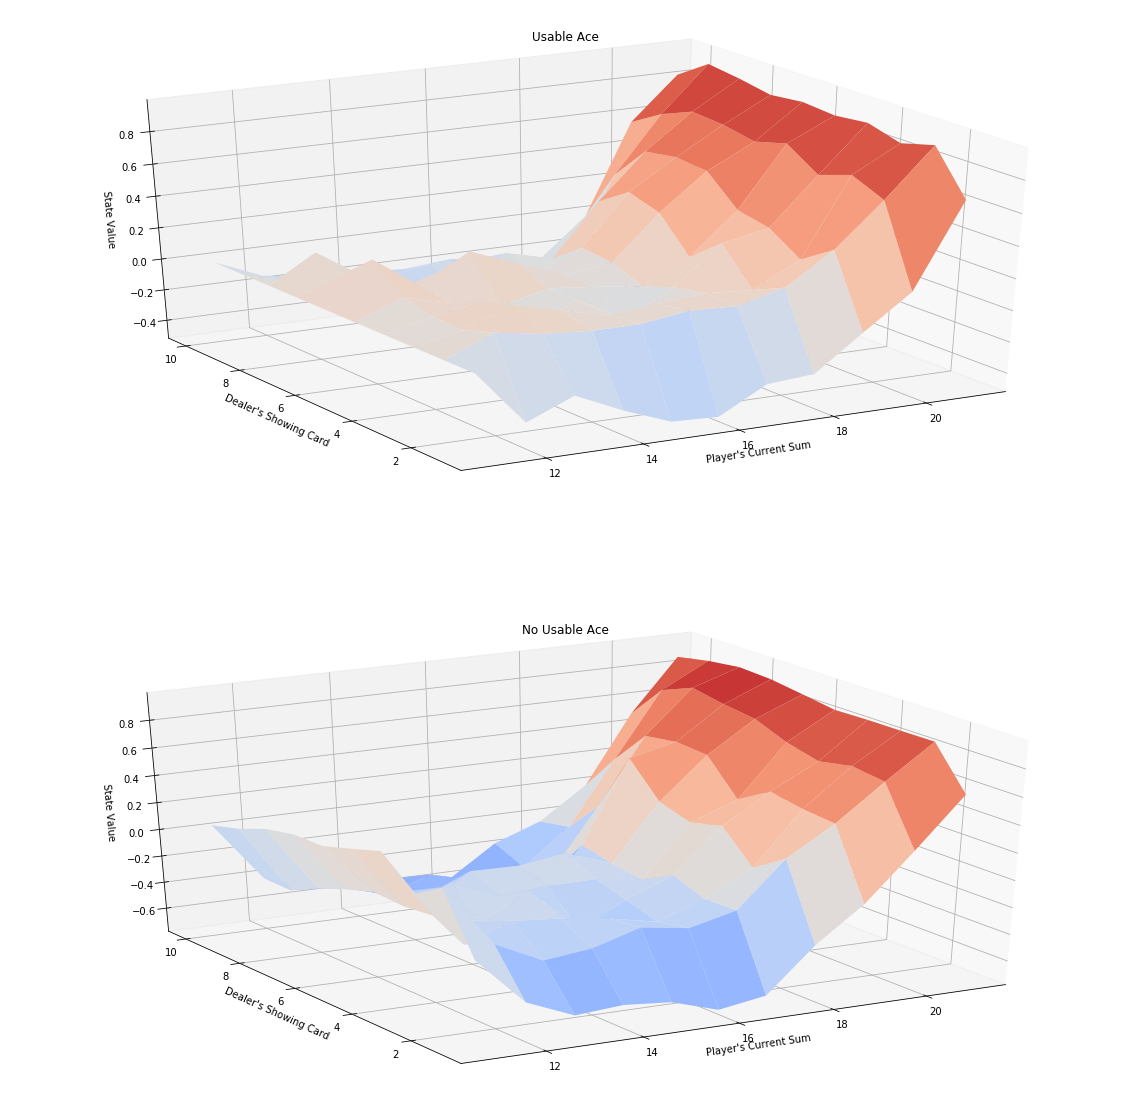

In [273]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

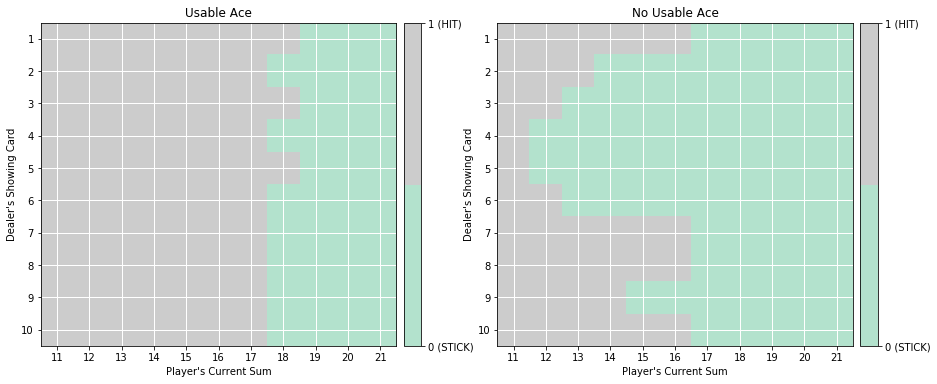

In [274]:
# plot the policy
plot_policy(policy)

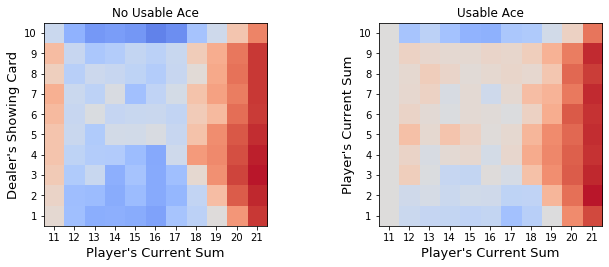

In [377]:
Q_array_noAce = np.zeros((11,10))
Q_array_Ace = np.zeros((11,10))

for x in np.arange(11, 22):
    for y in np.arange(10, 0, -1):
        if (x,y,False) in Q:
            Q_array_noAce[x-11,y-1] = np.max(np.array([Q[x,y,False]]))
        else:
            pass
        if (x,y,True) in Q:
            Q_array_Ace[x-11,y-1] = np.max(np.array([Q[x,y,True]]))
        else:
            pass

Q_array_noAce = Q_array_noAce.T
Q_array_Ace = Q_array_Ace.T

fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False, figsize = (10,20))

plt.setp((ax1,ax2), xticks=np.arange(11), xticklabels=np.arange(11,22),
        yticks=np.arange(10), yticklabels=np.arange(10, 0, -1))
plt.subplots_adjust(wspace=0.5)

ax1.imshow(Q_array_noAce, cmap='coolwarm', vmin = -1, vmax = 1)
ax1.set_xlabel("Player's Current Sum", fontsize=13);
ax1.set_ylabel("Dealer's Showing Card", fontsize=13);
ax1.set_title('No Usable Ace');

ax2.imshow(Q_array_Ace, cmap='coolwarm', vmin = -1, vmax = 1)
ax2.set_ylabel("Player's Current Sum", fontsize=13);
ax2.set_xlabel("Player's Current Sum", fontsize=13);
ax2.set_title('Usable Ace');


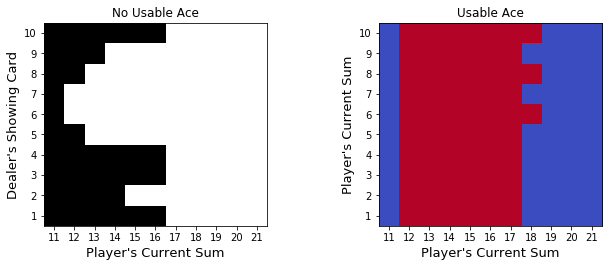

In [380]:
p_array_noAce = np.zeros((11,10))
p_array_Ace = np.zeros((11,10))

for x in np.arange(11, 22):
    for y in np.arange(10, 0, -1):
        if (x,y,False) in Q:
            p_array_noAce[x-11,y-1] = np.argmax(np.array([Q[x,y,False]]))
        else:
            pass
        if (x,y,True) in Q:
            p_array_Ace[x-11,y-1] = np.argmax(np.array([Q[x,y,True]]))
        else:
            pass

p_array_noAce = p_array_noAce.T
p_array_Ace = p_array_Ace.T

fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False, figsize = (10,20))

plt.setp((ax1,ax2), xticks=np.arange(11), xticklabels=np.arange(11,22),
        yticks=np.arange(10), yticklabels=np.arange(10, 0, -1))
plt.subplots_adjust(wspace=0.5)

ax1.imshow(p_array_noAce, cmap='binary', vmin = 0, vmax = 1)
ax1.set_xlabel("Player's Current Sum", fontsize=13);
ax1.set_ylabel("Dealer's Showing Card", fontsize=13);
ax1.set_title('No Usable Ace');

ax2.imshow(p_array_Ace, cmap='coolwarm', vmin = 0, vmax = 1)
ax2.set_ylabel("Player's Current Sum", fontsize=13);
ax2.set_xlabel("Player's Current Sum", fontsize=13);
ax2.set_title('Usable Ace');